In [1]:
import time
import random

# Demonstration of Fault-tolerance on the IBM 5Q chip

###### Contributor : 
Christophe Vuillot
###### Affiliations :
JARA Institute for Quantum Information, RWTH Aachen university

### Introduction

This notebook uses the IBM 5Q chip to demonstrate fault-tolerant behavior of a small quantum error detection code, the [[4,2,2]] code.
The idea is to compare some bare circuits on two qubits with their encoded version in the [[4,2,2]] code.
The chosen circuits are ones that have some fault-tolerant implementation in the [[4,2,2]] code.
In practice, not all are completely fault-tolerant due to the restricted connectivity of the IBM 5Q chip but close enough to show some improvement  !

One can prepare |00>, |0+> or |00>+|11> almost fault-tolerantly :
The preparation of |00> and |0+> can suffer an undetected X1.X2 error.

The gates X1, X2, Z1, Z2 (Pauli matrices), H1.H2.SWAP (two Hadamards and a SWAP) and CZ (controlled phase) can be done fault tolerantly.

More detailed information can be found at https://arxiv.org/abs/1610.03507, and 'insert my paper here'.

### Preparing the circuits
In order to fairly compare the encoded implementation to the bare implementation, one has to chose the best two qubits to represent the bare version. The possible pairs are listed below, chose the one with the lowest error rates at the time of doing the experiement.

In [2]:
possible_pairs = [[0,1],[0,2],[1,2],[3,2],[3,4],[4,2]]
cp = 1 #the chosen pair

The file Experiment_tools.py contains one function creating all the qasm code circuits depending on the chosen qubits for the bare version.

In [3]:
# Creating the circuits with misc info
from tools.Experiment_tools import *
all_circuits = create_all_circuits(possible_pairs[cp])

# Printing summary
template = "{input_state:9}\t|\t{circuit_desc:12}"
print('Summary of the circuits that will be tested :\n')
print(template.format(circuit_desc="Gate sequence", input_state="input state"))
print('--------------------------------------')
for rec in all_circuits: 
    print(template.format(**rec))

# Creating job batches to be run 
qasm_batch_bare = [{'qasm':c['qasm_bare']} for c in all_circuits]
qasm_batch_encoded = [{'qasm':c['qasm_encoded']} for c in all_circuits]

Summary of the circuits that will be tested :

input state	|	Gate sequence
--------------------------------------
|00>     	|	X1 HHS CZ X2
|00>     	|	HHS Z1 CZ   
|00>     	|	HHS Z1 Z2   
|00>     	|	HHS Z2 CZ   
|00>+|11>	|	Z2 X2       
|0+>     	|	X1 Z2       
|00>     	|	HHS Z1      
|00>     	|	HHS CZ      
|00>     	|	X1 X2       
|00>     	|	HHS Z2      
|00>+|11>	|	X1          
|0+>     	|	X1          
|00>     	|	HHS         
|00>+|11>	|	Z2          
|0+>     	|	Z2          
|00>     	|	X1          
|00>     	|	X2          
|00>+|11>	|	            
|0+>     	|	            
|00>     	|	            


### Connecting to the chip
Connecting with the IBM 5Q chip
(Needs a correct file Qconfig.py with a correct token for the API, see at https://quantumexperience.ng.bluemix.net)

In [4]:
from IBMQuantumExperience import IBMQuantumExperience
import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken,Qconfig.config)

### Running the experiment
Configure on which device you want to run the experiment ('real' is advised to do an actual test but it requires credits from the Quantum Experience).
Configure also how many runs for each version and how many shots (< 8192) per run.

In [5]:
device = 'real'
N_bare = 0
N_encoded = 0
shots = 8192

In [6]:
# Running the bare version of the circuits

f_bare = open('data/'+device+'_bare_experiment_ids.txt', 'a')

# Launching the jobs for the bare circuits onto the chip
# The IDs of the jobs together with the index of the chosen pair of qubits
# are also stored in the file device_bare_experiment_ids.txt
results_bare_list = []
for k in range(0,N_bare):
    out_tmp = api.run_job(qasm_batch_bare, device = device, shots = shots, max_credits=5)
    f_bare.write(out_tmp['id']+','+str(cp)+'\n')
    results_bare_list.append(api.get_job(out_tmp['id']))

# Waiting for the jobs to finish
i_running = range(0,N_bare)
n_running = len(i_running)
print('\nBare circuits running... (can take several minutes)\n')
print('Still '+str(len(i_running))+' running...\n')
while (True in [results_bare_list[k]['status'] == 'RUNNING' for k in i_running]):
    i_running = [k for k in i_running if results_bare_list[k]['status'] == 'RUNNING']
    if len(i_running)!=n_running:
        print('Still '+str(len(i_running))+' running...\n')
        n_running = len(i_running)
    time.sleep(3)
    for k in i_running:
        results_bare_list[k] = api.get_job(results_bare_list[k]['id'])
        
print('All completed !\n')
f_bare.close()


Bare circuits running... (can take several minutes)

Still 0 running...

All completed !



In [7]:
# Running the encoded version of the circuits

f_encoded = open('data/'+device+'_encoded_experiment_ids.txt', 'a')


# Launching the jobs for the encoded circuits onto the chip
# The IDs of the jobs are stored in the file device_encoded_experiment_ids.txt
results_encoded_list = []
for k in range(0,N_encoded):
    out_tmp = api.run_job(qasm_batch_encoded, device = device, shots = shots, max_credits=5)
    f_encoded.write(out_tmp['id']+'\n')
    results_encoded_list.append(api.get_job(out_tmp['id']))

# Waiting for the jobs to finish
i_running = range(0,N_encoded)
n_running = len(i_running)
print('\nEncoded circuits running... (can take several minutes)\n')
print('Still '+str(len(i_running))+' running...\n')
while (True in [results_encoded_list[k]['status'] == 'RUNNING' for k in i_running]):
    i_running = [k for k in i_running if results_encoded_list[k]['status'] == 'RUNNING']
    if len(i_running)!=n_running:
        print('Still '+str(len(i_running))+' running...\n')
        n_running = len(i_running)
    time.sleep(.1)
    for k in i_running:
        results_encoded_list[k] = api.get_job(results_encoded_list[k]['id'])
        
print('All completed !\n')
f_encoded.close()


Encoded circuits running... (can take several minutes)

Still 0 running...

All completed !



### Aggregating all the previously ran experiments
All the runs are stored using their ids in the files real_bare_experiment_ids.txt and real_encoded_experiment_ids.txt, if you had previously run the circuits their results are also gathered to analyse all the data existing at the same time.

In [8]:
print('Fetching all previous experiments for the bare versions of the circuits... (can take minutes)')

f_bare = open('data/'+device+'_bare_experiment_ids.txt', 'r')

results_bare_list = []
cps = []
for line in f_bare:
    id_string, cp_string = line.split(',')
    results_bare_list.append(api.get_job(id_string))
    cps.append(int(cp_string))

f_bare.close()
print('...Done.')

print('Fetching all previous experiments for the encoded versions of the circuits...(can take minutes)')

f_encoded = open('data/'+device+'_encoded_experiment_ids.txt', 'r')

results_encoded_list = []
for line in f_encoded:
    results_encoded_list.append(api.get_job(line.rstrip()))
    
f_encoded.close()
print('...Done.')


Fetching all previous experiments for the bare versions of the circuits... (can take minutes)
...Done.
Fetching all previous experiments for the encoded versions of the circuits...(can take minutes)
...Done.


### Analysing the results
For each individual circuit and run we analyse the output distribution and can compare it to the expected one.

In [9]:
analysed_bare = []
analysed_encoded = []

for j, res in enumerate(results_bare_list):
    analysed_bare.append([])
    for k in range(0,20):
        analysed_bare[j].append(analysis_one_bare_expe(res['qasms'][k],all_circuits[k],possible_pairs[cps[j]]))

for j, res in enumerate(results_encoded_list):
    analysed_encoded.append([])
    for k in range(0,20):
        analysed_encoded[j].append(analysis_one_encoded_expe(res['qasms'][k],all_circuits[k]))

We can look at random example from the set of runs, for example for the first circuit : X2 CZ HHS X1 |00>

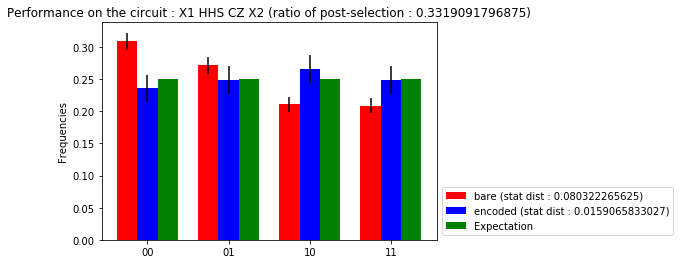

In [10]:
plot_one_expe(analysed_bare[random.randrange(len(analysed_bare))][0],analysed_encoded[random.randrange(len(analysed_bare))][0],0.99)

We should see that the encoded version is much more evenly distributed whereas the bare version shows suffering from decay errors.

As another example we can look at the circuit : X1 X2 |00>

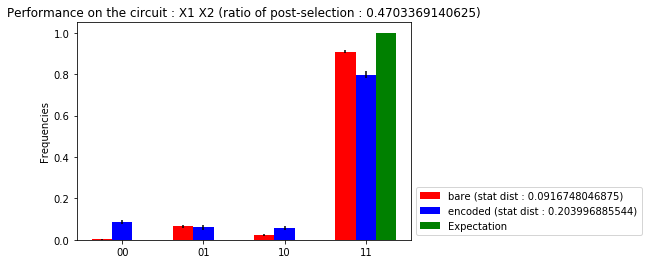

In [11]:
plot_one_expe(analysed_bare[random.randrange(len(analysed_bare))][8],analysed_encoded[random.randrange(len(analysed_encoded))][8],0.99)

We should see the bare version being much more accurate and note that the most common error for the encoded version is precisely X1.X2.

### Computing average performances for each circuit
We now look at the average performances over all runs for each circuit, comparing the statistical distance of the observed output distribution to the expected one.
We show the difference between the statistical distance of the encoded version minus the bare version.

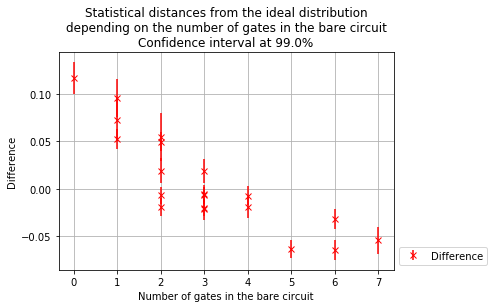

In [12]:
all_expe = analyse_all_expe(analysed_bare, analysed_encoded, .99)
plot_stat_dist(all_expe)

### Classifying circuits
Finally we can classify the circuits depending on if the encoding actually improve the performances.

### Circuits better encoded

In [13]:
print('Circuit that are improved when encoded : ')
print('-----------------------------------------')
template = "{input_state:9}\t|\t{circuit_desc:12}"
print(template.format(circuit_desc="Gate sequence", input_state="input state"))
print('--------------------------------------')
for rec in [c for c in all_expe if c['bare_mean_stat_dist']>c['encoded_mean_stat_dist']]: 
    print(template.format(**rec))

Circuit that are improved when encoded : 
-----------------------------------------
input state	|	Gate sequence
--------------------------------------
|00>     	|	X1 HHS CZ X2
|00>     	|	HHS Z1 CZ   
|00>     	|	HHS Z1 Z2   
|00>     	|	HHS Z2 CZ   
|00>+|11>	|	Z2 X2       
|00>     	|	HHS Z1      
|00>     	|	HHS CZ      
|00>     	|	HHS Z2      
|00>+|11>	|	X1          
|00>     	|	HHS         
|00>+|11>	|	Z2          
|00>+|11>	|	            


### Circuits better bare

In [14]:
print('\n\nCircuit that are better off performed bare : ')
print('--------------------------------------------')
template = "{input_state:9}\t|\t{circuit_desc:12}"
print(template.format(circuit_desc="Gate sequence", input_state="input state"))
print('--------------------------------------')
for rec in [c for c in all_expe if c['bare_mean_stat_dist']<c['encoded_mean_stat_dist']]: 
    print(template.format(**rec))



Circuit that are better off performed bare : 
--------------------------------------------
input state	|	Gate sequence
--------------------------------------
|0+>     	|	X1 Z2       
|00>     	|	X1 X2       
|0+>     	|	X1          
|0+>     	|	Z2          
|00>     	|	X1          
|00>     	|	X2          
|0+>     	|	            
|00>     	|	            


We can see that the fault-tolerant circuits or the states whose output distribution is unchanged by the eventual X1.X2 errors perform better encoded.